# Imports

In [17]:
import db_connection as db
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

It is important to create a "settings.ini" file that will contain the necessary parameters (database config parameters, in this case) for the "cfg.py" script. The format of this file will be:
<br>
<br>
[settings]<br>
DB_PASS=example_pass<br>
DB_USER=postgres<br>
DB_NAME=postgres<br>
DB_HOST=127.0.0.1<br>
DB_PORT=5432<br>
<br>
This is the configuration that a local postgreSQL database needs in order to create a connection with python 3. Note that this is a standard configuration and details may vary depending on the configuration of your own database.

# Functions definition

## PHASE 1: ETL

First, we need to set the client that will be used to get data from BigQuery. In this case, we created a .json key from our Google Cloud project and downloaded it to use it in our "src/" repository folder:

In [18]:
# Google Cloud BigQuery client for extracting raw data
client = bigquery.Client()

Next, we will define our 3 steps for data gathering:<br>

- <strong>extract</strong>: step that contains the query which extracts raw information from our chosen dataset.
- <strong>transform</strong>: step that cleans the retrieved data from previous step. In this case, 5 columns that the own code describes.
- <strong>load</strong>: step that loads the clean data in our database. <em>Note</em> that between this step and the previous one we will train our neural network in order to save our prediction.

In [19]:
def extract():
    query = "SELECT * FROM `housecanary-com.sample.zip_ts` LIMIT 2000"

    query_job = client.query(query)

    return query_job


def transform(data_raw):
    '''
    columns that will be saved (from 'zip_ts' table from dataset ):
        - zip (string): 5 digit postal code
        - msa (string): 5 digit Metropolitan Statistical Area code
        - month (date): timeseries date
        - hpi_value (float): nominal housing price index
        - hpi_real (float): real housing price index after adjusting nominal hpi for inflation as measured by the CPI
    '''

    # Selecting desired columns and saving them in a list for filtering next
    selected_columns = ['zip', 'msa', 'month', 'hpi_value', 'hpi_real']

    # Getting DataFrame from previous query result
    df_clean = data_raw.to_dataframe()

    # Filtering columns given selected columns list
    df_clean: DataFrame = df_clean.loc[:, selected_columns]

    # Cleaning data from NaN values in hpi_value and hpi_real
    df_clean = df_clean[df_clean.hpi_value.notnull()]
    df_clean = df_clean[df_clean.hpi_real.notnull()]

    return df_clean


def load(conn, df):
    # Table and Schema
    table_name = "zip_ts_raw"
    schema_name = "public"
    
    db.insert_rows(df, table_name, schema_name, conn)

## PHASE 2: AI training

In this phase, we will create a tensorflow model that will use the retrieved and cleaned data from previous our ETL phase.

Text(0.5, 0, 'parameters')

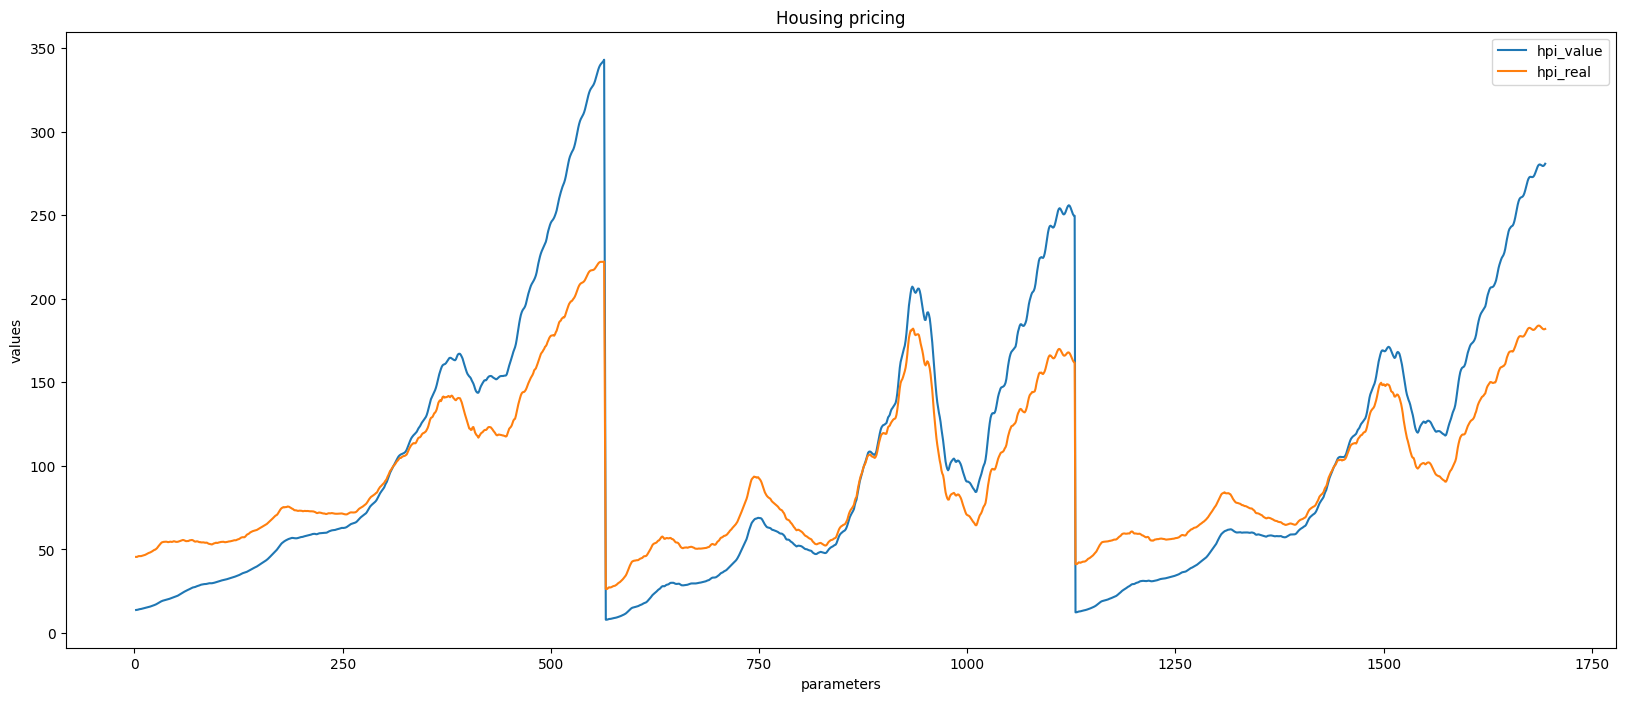

In [21]:
# Retrieving raw data from Google Cloud Platform dataset (House-canary)
data_raw = extract()

# Transforming raw data into processed data for database
data_processed = transform(data_raw)

data_processed.plot(kind='line', figsize=(20,8))
plt.title('Housing pricing')
plt.ylabel('values')
plt.xlabel('parameters')

In [ ]:
# Divide data in features (X) and labels (y)
X = data_processed.drop(['zip', 'msa'], axis=1)  # Delete 'zip' and 'msa' columns because they are not numerical
y = data_processed[['zip', 'msa', 'hpi_value', 'hpi_real']]

# Divide data in test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features in order to increase model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5)  # 5 output neurons to predict 5 columns
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Convert all columns to float32 data type
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Train model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

model, X_test_scaled, y_test